In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
EPSILON = 0.03
ALPHA = 0.01 

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def load_model(pretrained=True):
    """Load the ResNet20 model for CIFAR-10"""
    model = torch.hub.load('chenyaofo/pytorch-cifar-models', 'cifar10_resnet20', pretrained=pretrained)
    model = model.to(device)
    return model

# Function to visualize images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Function to show sample images
def show_random_images():
    # Get random images
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    
    # Show images
    imshow(torchvision.utils.make_grid(images[:4]))
    # Print labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Fast Gradient Sign Method (FGSM) attack
def fgsm_attack(image, epsilon, data_grad):

    # Get the sign of the gradient
    sign_data_grad = data_grad.sign()
    
    # Create perturbed image
    perturbed_image = image + epsilon * sign_data_grad
    
    # Clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image


def pgd_attack(model, images, labels, epsilon, alpha, num_iter=10):

    # Clone the images to avoid modifying them in-place
    images = images.clone().detach()
    
    # Initialize with a small random perturbation
    delta = torch.zeros_like(images).uniform_(-epsilon, epsilon).to(device)
    delta = torch.max(torch.min(delta, 1-images), -images)
    
    for _ in range(num_iter):
        # Set requires_grad to True for the iteration
        delta = delta.clone().detach().requires_grad_(True)
        
        # Forward pass
        adv_images = images + delta
        outputs = model(adv_images)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        # Backward pass
        model.zero_grad()
        loss.backward()
        
        # Update delta with the sign of gradient
        grad_sign = delta.grad.sign()
        delta = delta.detach() + alpha * grad_sign
        
        # Project back to epsilon ball
        delta = torch.clamp(delta, -epsilon, epsilon)
        
        # Project back to valid image space [0, 1]
        delta = torch.max(torch.min(delta, 1-images), -images)
    
    # Final adversarial examples
    adv_images = images + delta.detach()
    adv_images = torch.clamp(adv_images, 0, 1)
    
    return adv_images

# Test the model against adversarial attacks
def test_adversarial(model, test_loader, epsilon, attack_type='fgsm'):
    correct = 0
    total = 0
    adv_examples = []
    
    for images, labels in tqdm(test_loader, desc=f"Testing against {attack_type}"):
        images, labels = images.to(device), labels.to(device)
        batch_size = images.size(0)
        
        images.requires_grad = True
        outputs = model(images)
        _, initial_pred = torch.max(outputs, 1)
        
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        model.zero_grad()
        
        loss.backward()
        
        if attack_type == 'fgsm':
            perturbed_images = fgsm_attack(images, epsilon, images.grad.data)
        elif attack_type == 'pgd':
            perturbed_images = pgd_attack(model, images, labels, epsilon, alpha=0.01, num_iter=10)
        else:
            raise ValueError("Attack type not recognized")
        
        with torch.no_grad():
            outputs = model(perturbed_images)
            _, final_pred = torch.max(outputs, 1)
            
            correct += (final_pred == labels).sum().item()
            total += batch_size
            
            if len(adv_examples) < 5:
                for i in range(min(batch_size, 5 - len(adv_examples))):
                    if final_pred[i] != labels[i] and initial_pred[i] == labels[i]:
                        adv_ex = perturbed_images[i].detach().cpu().numpy()
                        adv_examples.append((initial_pred[i].item(), final_pred[i].item(), adv_ex))
                        if len(adv_examples) >= 5:
                            break
    
    final_acc = correct / total
    print(f"Epsilon: {epsilon}\tTest Accuracy = {final_acc * 100:.2f}%")
    
    return final_acc, adv_examples

def adversarial_train(model, train_loader, epsilon, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
        
        for i, (images, labels) in progress_bar:
            images, labels = images.to(device), labels.to(device)
            
            images.requires_grad = True
            outputs = model(images)
            model.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            
            perturbed_images = fgsm_attack(images, epsilon, images.grad.data)
            
            images.requires_grad = False
            images = torch.cat([images, perturbed_images])
            labels = torch.cat([labels, labels])
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            progress_bar.set_postfix({
                'loss': running_loss/(i+1),
                'acc': 100.*correct/total
            })
        
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Acc: {100.*correct/total:.2f}%")
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        print(f"Test Accuracy: {100.*correct/total:.2f}%")
    
    return model

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified


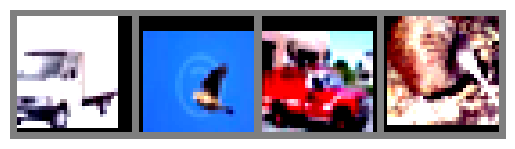

truck  bird truck  bird


In [3]:
show_random_images()

In [4]:
model = load_model(pretrained=True)
model.eval()

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/chenyaofo/pytorch-cifar-models/releases/download/resnet/cifar10_resnet20-4118986f.pt" to /root/.cache/torch/hub/checkpoints/cifar10_resnet20-4118986f.pt
100%|██████████| 1.09M/1.09M [00:00<00:00, 22.2MB/s

CifarResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [5]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing clean accuracy"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on clean test images: {100 * correct / total:.2f}%")

Testing clean accuracy: 100%|██████████| 79/79 [00:02<00:00, 26.47it/s]

Accuracy on clean test images: 92.60%


Testing against fgsm: 100%|██████████| 79/79 [00:03<00:00, 22.16it/s]


Epsilon: 0.01	Test Accuracy = 46.22%


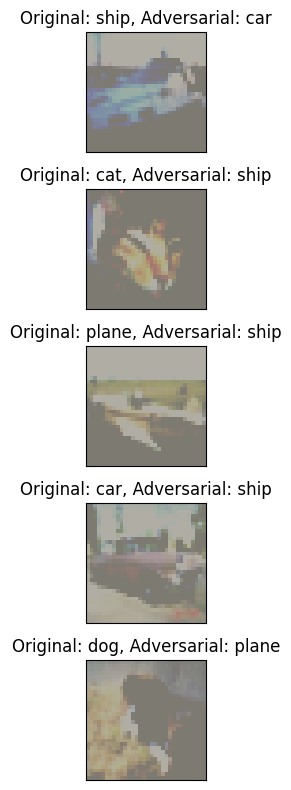

Testing against fgsm: 100%|██████████| 79/79 [00:03<00:00, 26.06it/s]


Epsilon: 0.03	Test Accuracy = 40.78%


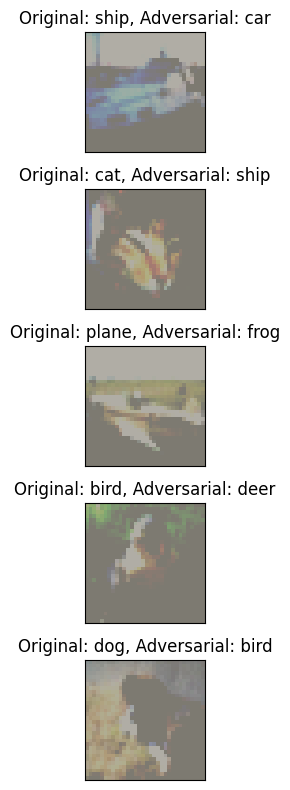

Testing against fgsm: 100%|██████████| 79/79 [00:02<00:00, 26.47it/s]


Epsilon: 0.05	Test Accuracy = 36.94%


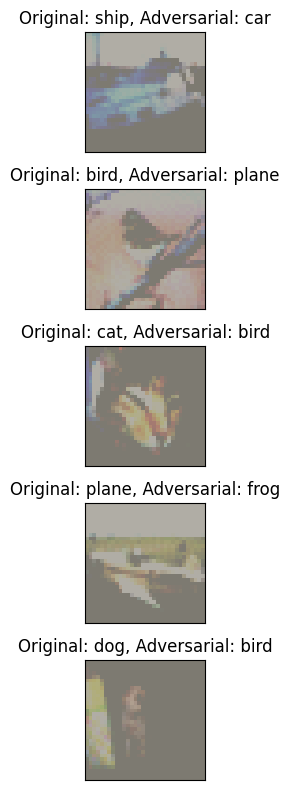

In [ ]:
 epsilons = [0.01, 0.03, 0.05]
for eps in epsilons:
    acc, adv_examples = test_adversarial(model, test_loader, eps, attack_type='fgsm')
    
    if len(adv_examples) > 0:
        cnt = 0
        plt.figure(figsize=(12, 8))
        for i in range(len(adv_examples)):
            cnt += 1
            plt.subplot(len(adv_examples), 1, cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            orig_pred, adv_pred, ex = adv_examples[i]
            plt.title(f"Original: {classes[orig_pred]}, Adversarial: {classes[adv_pred]}")
            ex = np.transpose(ex, (1, 2, 0))
            ex = ex * np.array((0.2023, 0.1994, 0.2010)) + np.array((0.4914, 0.4822, 0.4465))
            ex = np.clip(ex, 0, 1)
            plt.imshow(ex)
        plt.tight_layout()
        plt.show()

In [11]:
robust_model = load_model(pretrained=True)
robust_model = adversarial_train(robust_model, train_loader, epsilon=EPSILON, epochs=20)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Epoch 1/20: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s, loss=0.552, acc=82.6]


Epoch 1/20, Loss: 0.5516, Acc: 82.64%
Test Accuracy: 91.24%


Epoch 2/20: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s, loss=0.462, acc=84.3]

Epoch 2/20, Loss: 0.4620, Acc: 84.29%


Test Accuracy: 91.70%


Epoch 3/20: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s, loss=0.442, acc=84.9]

Epoch 3/20, Loss: 0.4416, Acc: 84.93%


Test Accuracy: 91.46%


Epoch 4/20: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s, loss=0.423, acc=85.5]

Epoch 4/20, Loss: 0.4227, Acc: 85.51%


Test Accuracy: 91.58%


Epoch 5/20: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s, loss=0.41, acc=86]   

Epoch 5/20, Loss: 0.4101, Acc: 85.99%


Test Accuracy: 91.47%


Epoch 6/20: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=0.402, acc=86.2]

Epoch 6/20, Loss: 0.4018, Acc: 86.19%


Test Accuracy: 91.65%


Epoch 7/20: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=0.393, acc=86.5]

Epoch 7/20, Loss: 0.3931, Acc: 86.50%


Test Accuracy: 91.57%


Epoch 8/20: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=0.385, acc=86.8]

Epoch 8/20, Loss: 0.3854, Acc: 86.79%


Test Accuracy: 91.70%


Epoch 9/20: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=0.378, acc=86.9]

Epoch 9/20, Loss: 0.3782, Acc: 86.90%


Test Accuracy: 91.86%


Epoch 10/20: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s, loss=0.375, acc=87.1]

Epoch 10/20, Loss: 0.3747, Acc: 87.08%


Test Accuracy: 91.79%


Epoch 11/20: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s, loss=0.369, acc=87.2]

Epoch 11/20, Loss: 0.3691, Acc: 87.23%


Test Accuracy: 91.66%


Epoch 12/20: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=0.368, acc=87.3]

Epoch 12/20, Loss: 0.3682, Acc: 87.26%


Test Accuracy: 91.70%


Epoch 13/20: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s, loss=0.36, acc=87.6] 

Epoch 13/20, Loss: 0.3596, Acc: 87.57%


Test Accuracy: 91.59%


Epoch 14/20: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=0.356, acc=87.8]

Epoch 14/20, Loss: 0.3563, Acc: 87.79%


Test Accuracy: 91.84%


Epoch 15/20: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s, loss=0.356, acc=87.7]

Epoch 15/20, Loss: 0.3560, Acc: 87.74%


Test Accuracy: 91.72%


Epoch 16/20: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=0.352, acc=87.8]

Epoch 16/20, Loss: 0.3518, Acc: 87.78%


Test Accuracy: 91.60%


Epoch 17/20: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=0.351, acc=87.9]

Epoch 17/20, Loss: 0.3507, Acc: 87.90%


Test Accuracy: 91.76%


Epoch 18/20: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=0.349, acc=88]  

Epoch 18/20, Loss: 0.3491, Acc: 87.95%


Test Accuracy: 91.80%


Epoch 19/20: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s, loss=0.347, acc=88.1]

Epoch 19/20, Loss: 0.3470, Acc: 88.08%


Test Accuracy: 91.67%


Epoch 20/20: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=0.35, acc=87.9] 


Epoch 20/20, Loss: 0.3500, Acc: 87.89%
Test Accuracy: 91.84%


In [12]:
for eps in epsilons:
        acc, _ = test_adversarial(robust_model, test_loader, eps, attack_type='fgsm')

Testing against fgsm: 100%|██████████| 79/79 [00:03<00:00, 24.81it/s]


Epsilon: 0.01	Test Accuracy = 77.71%


Testing against fgsm: 100%|██████████| 79/79 [00:03<00:00, 25.10it/s]


Epsilon: 0.03	Test Accuracy = 71.74%


Testing against fgsm: 100%|██████████| 79/79 [00:03<00:00, 24.50it/s]

Epsilon: 0.05	Test Accuracy = 66.09%


In [13]:
print("Testing against PGD attack...")
acc, _ = test_adversarial(robust_model, test_loader, EPSILON, attack_type='pgd')

Testing against PGD attack...


Testing against pgd: 100%|██████████| 79/79 [00:27<00:00,  2.82it/s]

Epsilon: 0.03	Test Accuracy = 44.71%


In [15]:
# 8. Save the robust model
print("Saving the robust model...")
save_path = './robust_cifar10_resnet20.pth'
torch.save(robust_model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Saving the robust model...
Model saved to ./robust_cifar10_resnet20.pth


In [16]:
from IPython.display import FileLink
FileLink(save_path)  # This creates a download link in Kaggle

/kaggle/working/robust_cifar10_resnet20.pth